# 1 - Imports

In [2]:
from bs4 import BeautifulSoup as bts
from datetime import datetime
from tabulate import tabulate

import requests
import pandas as pd
import numpy as np
import re
import seaborn as sns
import sweetviz as sv
import matplotlib.pyplot as plt

pd.set_option('display.float_format', '{:.2f}'.format)

# 2 - Helper Functions

## 2.1 - Data processing

In [3]:
def describe(data):
    
    num_attributes = data.select_dtypes( include=['int64', 'float64'] )
    media = pd.DataFrame( num_attributes.apply( np.mean ) )
    mediana = pd.DataFrame( num_attributes.apply( np.median ) )
    std = pd.DataFrame( num_attributes.apply( np.std ) )

    max_ = pd.DataFrame( num_attributes.apply( np.max ) ) 
    min_ = pd.DataFrame( num_attributes.apply( np.min ) ) 

    df_sc = pd.concat([max_, min_, media, mediana, std], axis=1 ).reset_index()
    df_sc.columns = ['attributes', 'max', 'min', 'mean', 'median', 'std']
    
    return df_sc





###################################################################
#                     Data Processing H&M
###################################################################

def dp_hm (path):
    
    data = pd.read_csv(path, sep=';')
    
    
    # Removendo dados duplicados
    
    data = data.drop_duplicates()
    
    
    # Removendo dados nulos/faltantes das principais colunas
    
    data = data.dropna(subset=['product_id', 'product_name', 'product_price', 'product_composition', 'product_fit'])
        
    
    # Removendo dados fora de contexto das principais colunas
    
    data = data.loc[~((data['product_fit'] == """The model is 189cm/6'2" and wears a size 31/32""") |
                     (data['product_fit'] == """The model is 187cm/6'2" and wears a size 31/32""")),:]
    
    data = data.reset_index(drop=True)
    
    return data



def column_hm(data):

    data['product_id'] = data['product_id'].astype('int64').astype('str')
    
    data['data_scrapy'] = data['data_scrapy'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y %H:%M"))
    data['data_year'] = data['data_scrapy'].apply(lambda x: x.year)
    data['data_month'] = data['data_scrapy'].apply(lambda x: datetime.strptime(str(x.month), '%m').strftime('%b'))
    data['data_day_name'] = data['data_scrapy'].apply(lambda x: datetime.strptime(str(x.day), '%d').strftime('%A'))
    data['data_day_number'] = data['data_scrapy'].apply(lambda x: x.day)
    
    data['product_price'] = data['product_price'].astype('float64')
    data['product_price_new'] = data['product_price_new'].astype('float64')
    
    return data


###################################################################
#                     Data Processing Macy's
###################################################################

def dp_macys (path2):
    
    data = pd.read_csv(path2)
    
    # Removendo dados duplicados
    
    data = data.drop_duplicates()
    
        
    # Extraindo o estilo da calça de 'product_ref'
    
    data['product_fit'] = data['product_ref'].apply(lambda x: 'Straight Jeans' if 'Straight' in x  else
                                                              'Straight Jeans' if 'Regular'  in x  else
                                                              'Bootcut Jeans'  if 'Bootcut'  in x  else
                                                              'Relaxed Jeans'  if 'Relaxed'  in x  else
                                                              'Skinny Jeans'   if 'Skinny'   in x  else
                                                              'Slim Jeans'     if 'Slim'     in x  else
                                                              'Baggy Jeans'    if 'Baggy'    in x  else
                                                              'Athletic Jeans' if 'Athletic' in x  else 
                                                              'Modern Jeans')
    
    return data



def column_macys(data):

    data['product_id'] = data['product_id'].astype('str')
    
    data['data_scrapy'] = data['data_scrapy'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    data['data_year'] = data['data_scrapy'].apply(lambda x: x.year)
    data['data_month'] = data['data_scrapy'].apply(lambda x: datetime.strptime(str(x.month), '%m').strftime('%b'))
    data['data_day_name'] = data['data_scrapy'].apply(lambda x: datetime.strptime(str(x.day), '%d').strftime('%A'))
    data['data_day_number'] = data['data_scrapy'].apply(lambda x: x.day)
    
    data['product_price'] = data['product_price'].astype('float64')
    data['product_sale'] = data['product_sale'].astype('float64')
    
    return data

## 2.2 - Regular expression

In [4]:
###################################################################
#                         Regex H&M
###################################################################

def regex_hm(data):
    
    # Extraindo informações da coluna 'product_composition'
    
    y = []
    
    regex = 'Shell:\s(.+%)[A-Z]|Shell:\s(.+%)'
    regex2 = 'Composition([Cotton].+%)[A-Z]|%([Cotton].+%)'
    regex3 = 'Composition([Cotton].+%)|%([Cotton].+%)'
        
    for i in range(len(data)):
        
        if "Shell" in data.loc[i, 'product_composition']:
            if re.search(regex, data.loc[i, 'product_composition']).group(2) == None:
                y.append(re.search(regex, data.loc[i, 'product_composition']).group(1))

            else:
                y.append(re.search(regex, data.loc[i, 'product_composition']).group(2))

        elif "Pocket" in data.loc[i, 'product_composition']:
            if re.search(regex2, data.loc[i, 'product_composition']).group(2) == None:
                y.append(re.search(regex2, data.loc[i, 'product_composition']).group(1))

            else:
                y.append(re.search(regex2, data.loc[i, 'product_composition']).group(2))
        
        elif "Lining" in data.loc[i, 'product_composition']:
            if re.search(regex2, data.loc[i, 'product_composition']).group(2) == None:
                y.append(re.search(regex2, data.loc[i, 'product_composition']).group(1))

            else:
                y.append(re.search(regex2, data.loc[i, 'product_composition']).group(2))
                
        else:
            if re.search(regex3, data.loc[i, 'product_composition']).group(2) == None:
                y.append(re.search(regex3, data.loc[i, 'product_composition']).group(1))

            else:
                y.append(re.search(regex3, data.loc[i, 'product_composition']).group(2))
        
    data1 = pd.DataFrame([y]).T
    data1.columns = ['product_composition']
    data1 = data1['product_composition'].str.split(',', expand=True)
    
    data_ref = pd.DataFrame(index=np.arange(len(data)) ,columns=['cotton', 'spandex', 'polyester', 'elastomultiester'])
    
    df_cotton = data1[0]
    df_cotton.name = 'cotton'
    data_ref = pd.concat([data_ref, df_cotton], axis=1)
    data_ref = data_ref.iloc[:, ~data_ref.columns.duplicated(keep='last')]
    
    
    df_spandex = data1.loc[data1[1].str.contains('Spandex', na=True),1]
    df_spandex.name = 'spandex'
    df_spandex = df_spandex.combine_first(data1[2])
    data_ref = pd.concat([data_ref, df_spandex], axis=1)
    data_ref = data_ref.iloc[:, ~data_ref.columns.duplicated(keep='last')] 
    data_ref['spandex'] = data_ref['spandex'].fillna('Spandex 0%')

    
    df_polyester = data1.loc[data1[1].str.contains('Polyester', na=True),1]
    df_polyester.name = 'polyester'
    data_ref = pd.concat([data_ref, df_polyester], axis=1)
    data_ref = data_ref.iloc[:, ~data_ref.columns.duplicated(keep='last')] 
    data_ref['polyester'] = data_ref['polyester'].fillna('Polyester 0%')

    
    df_elasto = data1.loc[data1[1].str.contains('Elastomultiester', na=True), 1]
    df_elasto.name = 'elastomultiester'

    data_ref = pd.concat([data_ref, df_elasto], axis=1)
    data_ref = data_ref.iloc[:, ~data_ref.columns.duplicated(keep='last')] 
    data_ref['elastomultiester'] = data_ref['elastomultiester'].fillna('Elastomultiester 0%')
    
    
    data = pd.concat([data, data_ref], axis=1)

    data['cotton'] = data['cotton'].apply(lambda x: int(re.search('\d+', x).group(0))/100)
    data['spandex'] = data['spandex'].apply(lambda x: int(re.search('\d+', x).group(0))/100)
    data['polyester'] = data['polyester'].apply(lambda x: int(re.search('\d+', x).group(0))/100)
    data['elastomultiester'] = data['elastomultiester'].apply(lambda x: int(re.search('\d+', x).group(0))/100)

    
    # Extraindo o preço das colunas 'product_price' e 'product_price_new'
    
    data['product_price'] = data['product_price'].apply(lambda x: re.search('\w.+', x).group(0))
    data['product_price_new'] = data['product_price_new'].apply(lambda x: re.search('\w.+', x).group(0) if pd.notnull(x) else x)
    data['product_price_new'] = data['product_price_new'].fillna(0)
    
    return data




###################################################################
#                         Regex Macy's
###################################################################

def regex_macys(data):
    
    # Extraindo os preços de venda e de promoção de 'product_price'
    
    regex = '.(\d+\.\d+)'
    regex2 = 'Sale..(\d+\.\d+)'
    
    
    data['product_sale'] = data['product_price'].apply(lambda x: re.search(regex2, x).group(1) if "Sale" in x else 0)
    data['product_price'] = data['product_price'].apply(lambda x: re.search(regex, x).group(1))
    
    data['product_sale'] = data['product_sale'].fillna(0)
    
    
    return data


## 2.3 - Plotting

In [5]:
def data_hist(data, x):
    
    sns.set_theme()
    fig, ax = plt.subplots(figsize=(8,6))
    sns.histplot(data=data, x=x, ax=ax)
    
    return None


# 3 - Web Scraping

Todas as extrações foram realizadas durante o mesmo período de doze dias.

## 3.1 - Web scraping H&M

A extração dos dados do site da H&M foi realizado com a biblioteca Selenium, sendo executado na IDE PyCharm. O arquivo ".py" pode ser encontrado no repositório.

## 3.2 - Web scraping Macy's

In [ ]:
url = 'https://www.macys.com/shop/mens-clothing/mens-jeans/Productsperpage/120?id=11221'

headers = {'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36'}

page = requests.get(url, headers=headers)

soup = bts(page.text, 'html.parser')

# Passo 1: Items da primeira página

    ##################################
    # Product id
    ##################################

    vitrine = soup.find('ul', class_='items grid-x small-up-2 medium-up-3 large-up-3')
    vitrine_items = vitrine.find_all('div', class_='productThumbnail redesignEnabled')
    product_id = [i.get('id') for i in vitrine_items]


    ##################################
    # Product name
    ##################################

    vitrine_name = vitrine.find_all('div', class_='productBrand')
    product_name = [i.get_text().strip() for i in vitrine_name]


    ##################################
    # Product reference
    ##################################

    vitrine_ref = vitrine.find_all('a', class_='productDescLink')
    product_ref = []

    for i in range(0, len(vitrine_ref), 2):

        product_ref.append(vitrine_ref[i].get('title'))


    ##################################
    # Product price
    ##################################

    vitrine_price = vitrine.find_all('div', class_='prices')
    product_price = [i.get_text().strip() for i in vitrine_price]


    
# Passo 2: Extraindo os dados de todas as páginas

    ##################################
    # Pagination
    ##################################

    j = soup.find('div', class_='cell small-12')
    k = j.find_all('option')


    for i in range(2, (len(k)+1)):

        url2 = 'https://www.macys.com/shop/mens-clothing/mens-jeans/Pageindex,Productsperpage/' + str(i) + ',120?id=11221'

        page2 = requests.get(url2, headers=headers)

        soup2 = bts(page2.text, 'html.parser')

        ##################################
        # Product id
        ##################################

        vitrine2 = soup2.find('ul', class_='items grid-x small-up-2 medium-up-3 large-up-3')
        vitrine_items2 = vitrine2.find_all('div', class_='productThumbnail redesignEnabled')
        product_id2 = [i.get('id') for i in vitrine_items2]

        product_id = [*product_id, *product_id2]


        ##################################
        # Product name
        ##################################

        vitrine_name2 = vitrine2.find_all('div', class_='productBrand')
        product_name2 = [i.get_text().strip() for i in vitrine_name2]

        product_name = [*product_name, *product_name2]


        ##################################
        # Product reference
        ##################################

        vitrine_ref2 = vitrine2.find_all('a', class_='productDescLink')
        product_ref2 = []

        for j in range(0, len(vitrine_ref2), 2):

            product_ref2.append(vitrine_ref2[j].get('title'))

        product_ref = [*product_ref, *product_ref2]

        ##################################
        # Product price
        ##################################

        vitrine_price2 = vitrine2.find_all('div', class_='prices')
        product_price2 = [i.get_text().strip() for i in vitrine_price2]

        product_price = [*product_price, *product_price2]

    

# Passo 3: Salvando os dados

data1 = pd.DataFrame([product_id, product_name, product_ref, product_price]).T
data1.columns = ['product_id', 'product_name', 'product_ref', 'product_price']
data1['data_scrapy'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

data = pd.read_csv('data.csv')

data_macys = pd.concat([data1, data], axis=0, ignore_index=True)

data_macys.to_csv('data.csv', index=False)

# 4 - Data Processing

## 4.1 - Processing H&M

### 4.1.1 - Dataframe

In [6]:
# Passo 1: Carregando os dados
data_hm = dp_hm('data_h&m.csv')


# Passo 2: Aplicando regex para tratar os dados
data_hm = regex_hm(data_hm)


# Passo 3: Modificando o tipo dos dados
data_hm = column_hm(data_hm)

data_hm.head()

,product_id,product_name,product_price,product_price_new,product_color,product_fit,product_size,product_materials,product_composition,data_scrapy,cotton,spandex,polyester,elastomultiester,data_year,data_month,data_day_name,data_day_number
0,1024256001,Slim Jeans,29.99,0.00,Black,Slim fit,"The model is 185cm/6'1"" and wears a size 31/32",Lining: Recycled cotton 20%,"CompositionPocket lining: Polyester 65%, Cotto...",2022-04-12 13:40:00,0.99,0.01,0.00,0.00,2022,Apr,Friday,12
1,1024256002,Slim Jeans,29.99,0.00,Light denim blue,Slim fit,"The model is 189cm/6'2"" and wears a size 31/32","Lining: Recycled polyester 65%, Recycled cotto...","CompositionShell: Cotton 99%, Spandex 1%Pocket...",2022-04-12 13:40:00,0.99,0.01,0.00,0.00,2022,Apr,Friday,12
2,1024256003,Slim Jeans,29.99,0.00,Light denim blue,Slim fit,"The model is 189cm/6'2"" and wears a size 31/32",Shell: Recycled cotton 20%,"CompositionShell: Cotton 99%, Spandex 1%Pocket...",2022-04-12 13:40:00,0.99,0.01,0.00,0.00,2022,Apr,Friday,12
3,1024256004,Slim Jeans,29.99,0.00,Denim blue,Slim fit,NaN,"Lining: Recycled polyester 65%, Recycled cotto...","CompositionShell: Cotton 99%, Spandex 1%Pocket...",2022-04-12 13:40:00,0.99,0.01,0.00,0.00,2022,Apr,Friday,12
4,1024256005,Slim Jeans,29.99,0.00,Dark blue,Slim fit,"The model is 180cm/5'11"" and wears a size 31/32",Shell: Recycled cotton 20%,"CompositionPocket lining: Polyester 65%, Cotto...",2022-04-12 13:40:00,0.99,0.01,0.00,0.00,2022,Apr,Friday,12


### 4.1.2 - Columns

In [8]:
data_hm.columns

Index(['product_id', 'product_name', 'product_price', 'product_price_new',
       'product_color', 'product_fit', 'product_size', 'product_materials',
       'product_composition', 'data_scrapy', 'cotton', 'spandex', 'polyester',
       'elastomultiester', 'data_year', 'data_month', 'data_day_name',
       'data_day_number'],
      dtype='object')

Descrição:

- product_id: Código de cada item para venda
- product_name: Nome do produto
- product_price: Preço do produto
- product_price_new: Preço de promoção do produto 
- product_color: Cor da calça
- product_fit: Estilo da calça jeans
- product_size: Tamanho do produto
- product_materials: Tipo de material que compõe o produto
- product_composition: Composição do produto
- data_scrapy: Data da extração de dados
- cotton: Porcentagem de algodão no produto
- spandex: Porcentagem de spandex no produto
- polyester: Porcentagem de polyester no produto
- elastomultiester: Porcentagem de elastomultiester no produto
- data_year: Ano da extração de dados
- data_month: Mês da extração de dados
- data_day_name: Dia da semana em que foi extraido os dados
- data_day_number: Dia da extração extração de dados

### 4.1.3 - Data dimension

In [9]:
print(f'A quantidade de linhas do dataframe é: {data_hm.shape[0]}')
print(f'A quantidade de colunas do dataframe é: {data_hm.shape[1]}')

A quantidade de linhas do dataframe é: 2380
A quantidade de colunas do dataframe é: 18


### 4.1.4 - Data types

In [10]:
data_hm.dtypes

product_id                     object
product_name                   object
product_price                 float64
product_price_new             float64
product_color                  object
product_fit                    object
product_size                   object
product_materials              object
product_composition            object
data_scrapy            datetime64[ns]
cotton                        float64
spandex                       float64
polyester                     float64
elastomultiester              float64
data_year                       int64
data_month                     object
data_day_name                  object
data_day_number                 int64
dtype: object

## 4.2 - Processing Macy's

### 4.2.1 - Dataframe

In [7]:
# Passo 1: Carregando os dados

data_macys = dp_macys('data_macys.csv')


# Passo 2: Aplicando regex para tratar os dados
data_macys = regex_macys(data_macys)


# Passo 3: Modificando o tipo dos dados
data_macys = column_macys(data_macys)

data_macys.head()

,product_id,product_name,product_ref,product_price,data_scrapy,product_fit,product_sale,data_year,data_month,data_day_name,data_day_number
0,1654744,Polo Ralph Lauren,Men's Hampton Relaxed Straight Jeans,98.50,2022-04-16 18:13:16,Straight Jeans,0.00,2022,Apr,Tuesday,16
1,1103208,Levi's,Men's 511™ Slim Fit Jeans,69.50,2022-04-16 18:13:16,Slim Jeans,59.99,2022,Apr,Tuesday,16
2,9617175,Levi's,Levi’s® Flex Men's 514™ Straight-Fit Jeans,69.50,2022-04-16 18:13:16,Straight Jeans,59.99,2022,Apr,Tuesday,16
3,6545489,Calvin Klein,Men's Slim-Fit Jeans,79.50,2022-04-16 18:13:16,Slim Jeans,0.00,2022,Apr,Tuesday,16
4,2834394,Levi's,Men's 502™ Taper Jeans,69.50,2022-04-16 18:13:16,Modern Jeans,59.99,2022,Apr,Tuesday,16


### 4.2.2 - Columns

In [12]:
data_macys.columns

Index(['product_id', 'product_name', 'product_ref', 'product_price',
       'data_scrapy', 'product_fit', 'product_sale', 'data_year', 'data_month',
       'data_day_name', 'data_day_number'],
      dtype='object')

Descrição:

- product_id: Código de cada item para venda
- product_name: Nome do produto/marca
- product_ref: Referência do produto
- product_price: Preço do produto
- data_scrapy: Data da extração de dados
- product_fit: Estilo da calça jeans
- product_sale: Preço de promoção do produto
- data_year: Ano da extração de dados
- data_month: Mês da extração de dados
- data_day_name: Dia da semana em que foi extraido os dados
- data_day_number: Dia da extração extração de dados

### 4.2.3 - Data dimension

In [13]:
print(f'A quantidade de linhas do dataframe é: {data_macys.shape[0]}')
print(f'A quantidade de colunas do dataframe é: {data_macys.shape[1]}')

A quantidade de linhas do dataframe é: 8942
A quantidade de colunas do dataframe é: 11


### 4.2.4 - Data types

In [14]:
data_macys.dtypes

product_id                 object
product_name               object
product_ref                object
product_price             float64
data_scrapy        datetime64[ns]
product_fit                object
product_sale              float64
data_year                   int64
data_month                 object
data_day_name              object
data_day_number             int64
dtype: object

# 5 - Hypotheses

- H1: O dia com mais promoções é na sexta-feira
- H2: O máximo de desconto que pode ser encontrado é de 60%
- H3: Os 5 modelos com maiores quantidades de calças, são as que possuem o valor em torno da mediana total
- H4: Calças com composição de algodão acima de 90%, custam acima do preço mediano
- H5: Items em promoção possuem cor clara

# 6 - EDA

## 6.1 - Describe

### 6.1.1 - Describe H&M

In [15]:
describe(data_hm)

,attributes,max,min,mean,median,std
0,product_price,119.99,11.99,44.62,39.99,25.62
1,product_price_new,39.99,0.00,2.82,0.00,7.96
2,cotton,1.00,0.77,0.97,0.99,0.06
3,spandex,0.02,0.00,0.01,0.01,0.01
4,polyester,0.21,0.00,0.02,0.00,0.06
5,elastomultiester,0.09,0.00,0.00,0.00,0.02
6,data_year,2022.00,2022.00,2022.00,2022.00,0.00
7,data_day_number,13.00,2.00,8.38,9.00,3.07


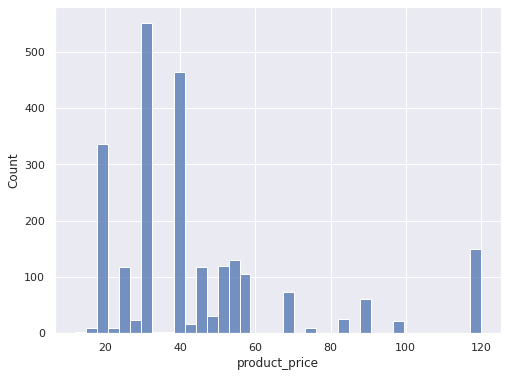

In [16]:
data_hist(data_hm, 'product_price')

Algumas considerações:

- O atributo 'product_price' representa o preço de venda normal dos items; é possível observar que o maior preço encontrado é de 119,99 dólares e o menor valor sendo 11,99 dólares;
- A média dos preços está em torno de 44,62 dólares, fazendo inferir que grande parte dos produtos possuem valores menores que o valor máximo;
- A mediana é a forma mais fiel para expressar a distribuição dos preços nessa situação em que não há uma distribuição normal, como observado no histograma acima. O valor mediano dos preços é de 39,99 dólares;
- No atributo 'product_price_new' representa os preços de promoção das calças. Os produtos com valor zero nesse atributo, significa que não teve preço de promoção. O maior valor encontrado foi de 39,99 dólares;
- As composições das calças estão representadas desde 'cotton' até 'elastomultiester'.

### 6.1.2 - Describe Macy's

In [17]:
describe(data_macys)

,attributes,max,min,mean,median,std
0,product_price,348.00,29.50,102.63,89.00,49.31
1,product_sale,167.30,0.00,15.84,0.00,29.28
2,data_year,2022.00,2022.00,2022.00,2022.00,0.00
3,data_day_number,16.00,2.00,8.92,9.00,4.34


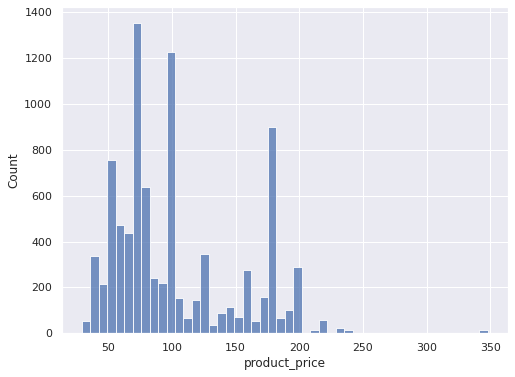

In [18]:
data_hist(data_macys, 'product_price')

Algumas considerações:

- O atributo 'product_price' representa o preço de venda normal dos items; é possível observar que o maior preço encontrado é de 119,99 dólares e o menor valor sendo 11,99 dólares;
- A média dos preços está em torno de 44,62 dólares, fazendo inferir que grande parte dos produtos possuem valores menores que o valor máximo;
- A mediana é a forma mais fiel para expressar a distribuição dos preços nessa situação em que não há uma distribuição normal, como observado no histograma acima. O valor mediano dos preços é de 39,99 dólares;
- No atributo 'product_price_new' representa os preços de promoção das calças. Os produtos com valor zero nesse atributo, significa que não teve preço de promoção. O maior valor encontrado foi de 39,99 dólares;
- As composições das calças estão representadas desde 'cotton' até 'elastomultiester'.

### 6.1.3 - Comparation

A principal diferença entre os dados das duas concorrentes é na informação de composição do que compõe as calças. Na H&M há os valores das porcentagens de cada componente, enquanto na Macy's as informações que são fornecidas sobre composição são somente quais componentes estão presentes. Porém, a informação mais crucial está nos preços de vendas. É notório a grande diferença entre os valores dos produtos vendidos entre as duas empresas, na H&M temos produtos mais baratos enquanto na Macy's mais caros, o que nos leva a inferir que a segunda fornece produtos de grife e consequentemente a primeira com produtos mais acessíveis.

Esse fator não descredibiliza e descarta o que foi extraído da Macy's. Podendo ser usado para melhor compreensão do comportamento dos preços e dessa forma analisar, de forma adequada, o mercado de calças e seus fenômenos.

## 6.2 - Answering the hypothesis

### 6.2.1 - H1: O dia com mais promoções é na sexta-feira

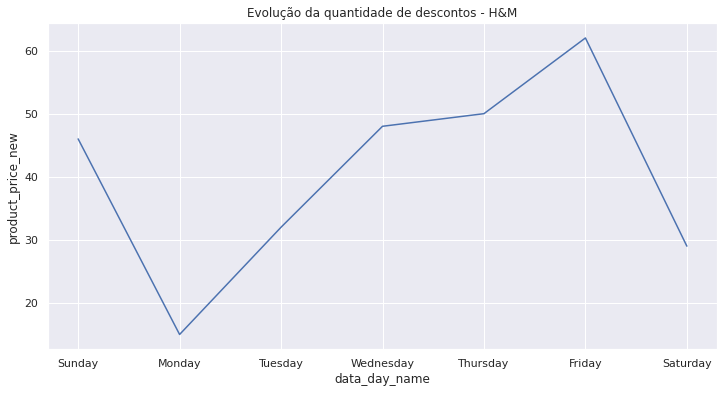

In [30]:
#######################################
# H1 - H&M
#######################################

data_1_1 = data_hm.loc[data_hm['product_price_new']>0, :]
data_aux1 = data_1_1[['data_day_name', 'product_price_new']].groupby('data_day_name').count().reset_index()

# Criando a ordem do dia da semana
data_aux1['data_day_name'] =  pd.Categorical(data_aux1['data_day_name'],
                                            categories = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                                            ordered=True)

sns.set_theme()
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=data_aux1, x='data_day_name', y='product_price_new', ax=ax)
plt.title('Evolução da quantidade de descontos - H&M')
plt.show()

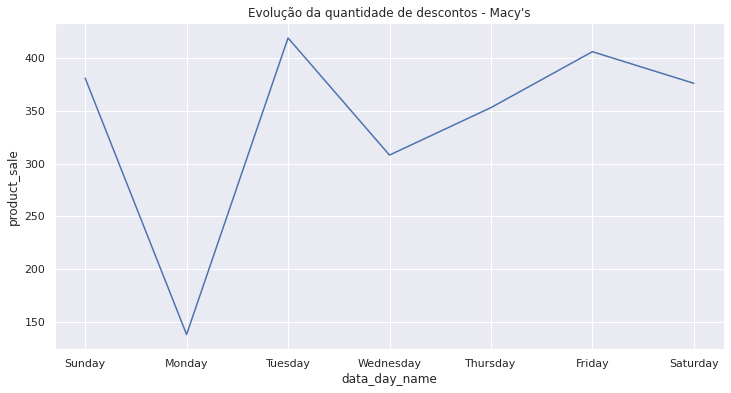

In [31]:
#######################################
# H3 - Macy's
#######################################

data_1_2 = data_macys.loc[data_macys['product_sale']>0, :]
data_aux2 = data_1_2[['data_day_name', 'product_sale']].groupby('data_day_name').count().reset_index()

data_aux2['data_day_name'] =  pd.Categorical(data_aux2['data_day_name'],
                                            categories = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                                            ordered=True)

sns.set_theme()
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=data_aux2, x='data_day_name', y='product_sale', ax=ax)
plt.title("Evolução da quantidade de descontos - Macy's")
plt.show()

Os comportamentos da quantidade de descontos por dia da semana, são similares nas duas lojas. Segue algumas considerações:
- Há uma grande queda de Domingo para Segunda, comportamento explicado pelo fato das pessoas voltarem para suas rotinas (trabalho, faculdade, etc) às Segundas, tendo menos tempo para acessar internet;
- Os maiores valores podem ser encontrado na Sexta-feira na H&M, na Macy's observa-se a maior quantidade na Terça-feira, no entanto os valores na Sexta são bem próximos. Esse comportamento é explicado pelo oposto do que ocorre de Domingo para Segunda. Nessa situação, as pessoas estão entrando no "final de semana", tendo mais tempo para navegação na internet e dessa forma passar mais tempo escolhendo algum produto que deseje comprar.

### 6.2.2 - H2: O máximo de desconto que pode ser encontrado é de 60%

In [29]:
#######################################
# H2 - H&M
#######################################

#Removendo valores sem desconto
data_2_1 = data_hm.loc[data_hm['product_price_new']>0, ['product_id', 'product_name', 'product_price', 'product_price_new', 'data_day_number', 'data_day_name']]

#Qual a % de desconto aplicado
data_2_1['%discount'] = data_2_1[['product_price', 'product_price_new']].apply(lambda x: 1-(x['product_price_new']/x['product_price']), axis=1)

#Desconto máximo e produto
discount_max = data_2_1['%discount'].max()
data_2_1 = data_2_1.loc[data_2_1['%discount']==discount_max,:]
dados_prod = dict(data_2_1.iloc[2,:])

print('\n'f"O produto {dados_prod['product_name']}, teve um desconto de {dados_prod['%discount']*100:.2f}%.")
print('\n'f"Esse produto custava U${dados_prod['product_price']:.2f} e com o desconto passou a ser U${dados_prod['product_price_new']:.2f}.")


O produto Slim Tapered Jeans, teve um desconto de 66.67%.

Esse produto custava U$89.99 e com o desconto passou a ser U$29.99.


In [63]:
#######################################
# H3 - Macy's
#######################################

#Removendo valores sem desconto
data_2_2 = data_macys.loc[data_macys['product_sale']>0, ['product_id', 'product_name', 'product_price', 'product_sale', 'data_day_number', 'data_day_name']]

#Qual a % de desconto aplicado
data_2_2['%discount'] = data_2_2[['product_price', 'product_sale']].apply(lambda x: 1-(x['product_sale']/x['product_price']), axis=1)

#Desconto máximo e produto
discount_max = data_2_2['%discount'].max()
data_2_2 = data_2_2.loc[data_2_2['%discount']==discount_max,:]
dados_prod = dict(data_2_2.iloc[2,:])

print('\n'f"O produto {dados_prod['product_name']}, teve um desconto de {dados_prod['%discount']*100:.2f}%.")
print('\n'f"Esse produto custava U${dados_prod['product_price']:.2f} e com o desconto passou a ser U${dados_prod['product_sale']:.2f}.")


O produto INC International Concepts, teve um desconto de 49.70%.

Esse produto custava U$79.50 e com o desconto passou a ser U$39.99.


### 6.2.3 - H3: Os 5 modelos com maiores quantidades de calças, são as que possuem o valor em torno da mediana total

In [34]:
#######################################
# H3 - H&M
#######################################

data_2_1 = data_hm[['product_name', 'product_id', 'product_price']].groupby('product_name').agg({'product_id':'count', 'product_price':'median'}).reset_index()
data_2_1 = data_2_1.rename(columns = {'product_id':'count_id', 'product_price':'median_price'})
data_2_1['Rank'] = data_2_1['count_id'].rank(ascending=False)
data_2_1.sort_values('Rank', inplace=True)
data_2_1 = data_2_1.loc[data_2_1['Rank']<6, :]
print(data_2_1)
print("\n\n")
print(f"A mediana dos total dos preços é de: {data_hm['product_price'].median()}")

          product_name  count_id  median_price  Rank
16          Slim Jeans       407         29.99  1.00
15        Skinny Jeans       361         19.99  2.00
7        Regular Jeans       358         48.99  3.00
19  Slim Tapered Jeans       253        119.99  4.00
10       Relaxed Jeans       182         53.99  5.00



A mediana dos total dos preços é de: 39.99


In [58]:
#######################################
# H2 - Macy's
#######################################

data_2_2 = data_macys[['product_name', 'product_id', 'product_price']].groupby('product_name').agg({'product_id':'count', 'product_price':'median'}).reset_index()
data_2_2 = data_2_2.rename(columns = {'product_id':'count_id', 'product_price':'median_price'})
data_2_2['Rank'] = data_2_2['count_id'].rank(ascending=False)
data_2_2.sort_values('Rank', inplace=True)
data_2_2 = data_2_2.loc[data_2_2['Rank']<6, :]
print(data_2_2)
print("\n\n")
print(f"A mediana dos total dos preços é de: {data_macys['product_price'].median():.2f}")

   product_name  count_id  median_price  Rank
22       Levi's      1089         69.50  1.00
16    Hugo Boss       912        178.00  2.00
30   RON TOMSON       504        180.00  3.00
4     COTTON ON       499         49.99  4.00
23  Lucky Brand       497         99.00  5.00



A mediana dos total dos preços é de: 89.00


### 6.2.4 - H4: Calças com composição de algodão acima de 90%, custam acima do preço mediano


In [25]:
#######################################
# H4 - H&M
#######################################

data_4_aux = data_hm.loc[data_hm['cotton']>0.9, :]
data_4 = data_4_aux[['product_id', 'product_name', 'product_price', 'cotton']].groupby('product_name').agg({'product_id':'count', 'product_price':'median', 'cotton':'mean'}).reset_index()
data_4.sort_values(ascending=False, by=['product_id'])

,product_name,product_id,product_price,cotton
13,Slim Jeans,407,29.99,0.99
12,Skinny Jeans,361,19.99,0.99
4,Regular Jeans,358,48.99,0.99
16,Slim Tapered Jeans,253,119.99,0.99
7,Relaxed Jeans,182,53.99,1.00
11,Skinny Cropped Jeans,150,29.99,0.99
1,Loose Jeans,94,39.99,1.00
5,Regular Tapered Crop Jeans,64,19.99,1.00
9,Relaxed Pull-on Jeans,56,24.99,1.00
10,Relaxed Tapered Pull-on Jeans,39,98.49,1.00


### 6.2.5 - H5: Items em promoção possuem cor clara

In [33]:
#######################################
# H5 - H&M
#######################################

data_5_aux = data_hm.loc[data_hm['product_price_new']>0, :]
data_5 = data_5_aux[['product_id', 'product_color', 'product_price_new']].groupby('product_color').agg({'product_id':'count', 'product_price_new':'mean'})
data_5.sort_values(ascending=False, by=['product_id'])

,product_id,product_price_new
product_color,,
Denim blue,108,24.42
Black,80,23.83
Dark denim blue,33,21.75
Light denim blue,31,29.41
Dark blue denim,12,18.99
Light blue,12,16.24
Dark gray,4,15.99
Dark blue,2,20.99


# 7 - Business case

O grande objetivo do projeto é responder as perguntas dos sócios da Star Jeans:
- Qual o melhor preço de venda para as calças?
- Quantos tipos de calças e suas cores para o produto inicial?
- Quais as matérias-primas necessárias para confeccionar as calças?

Além da resposta para esses questionamentos, qual seria o investimento inicial no negócio?
Para entender melhor qual o investimento que será feito, a matéria-prima e os custos que há na confecção das roupas, é preciso analisar os processos de fabricação. Na confecção de roupas, é possível observar que há os seguintes custos:

- Custos com matéria-prima:
    - Tecido;
    - Entretela;
    - Botão;
    - Zíper;
    - Linha;
    - Etiqueta;
    - Tag;
    - Embalagem.
- Custos com mão de obra;
- Custos com energia; e
- Custos com impostos.

Em cada um dos items acima, há uma forma de estimar os custos e serão descritos abaixo.

## 7.1 Custos com matéria-prima

Todos os preços que serão mencionados aqui, foram retirados de lojas online especializadas em vendas de produtos para confecção. O que isso significa? Que o valor final será uma estimativa, na realidade as matérias-primas são compradas em atacado, com preços bem menores, fazendo assim com que haja um custo inferior nessa etapa.

Medidas de uma calça jeans masculina:

<img src = "https://static.homemecia.com.br/public/homemecia/imagens/produtos/tabela_tamanho/dac739c505a832fe637926c2498e3127.jpg">

### 7.1.1 Custo do tecido

Nessa etapa, será considerado uma calça jeans do tamanho 42 como exemplo de estimativa para os custos. O cálculo para o tecido que será utilizado, é baseado na área de uma calça, para isso é preciso pegar a altura e o tamanho do quadril (maior que a cintura).

Alguns sites indicam que para haver uma quantidade extra de tecido para costuras e bainhas, é necessário adicionar cerca de 20 centímetros de tecido na altura da calça. A fórmula que será utilizada é básica: 

<b> Área = (altura + 20cm) * quadril</b>

Substituindo os valores para uma calça de tamanho 42:

<b> Área = (105 + 20cm) * 52</b>

Dessa forma tem-se um valor de <b>6500cm²</b>, transformando em metros quadrados <b>0,65m²</b>.

Pesquisando em algumas lojas virtuais, foi possível obter um valor de tecido por volta de <b> R&#36; 21,76 por m²</b>. Isso sendo um tecido feito totalmente de algodão. Efetuando uma simples "regra de 3" pode-se obter o valor de 0,65m². O valor para cada calça seria de <b> R&#36; 14,14 </b>.

### 7.1.2 Entretela

Entretela é usado para estabilizar, encorporar e estabilizar o tecido que será bordado. Em lojas virtuais, o valor da entretela é de R&#36; 13,33 por m². A recomendação é utilizar 0,07cm desse material, dessa forma precisamos determinar o valor do metro desse componente:

m² = 40/3 --> <b> m = 3,65 </b>


Como é preciso cerca de 0,07cm de entretela, aplicando uma proporção obtemos um valor de <b> R&#36; 2,65.10⁻³</b>.

### 7.1.3 Custo do botão

Um pacote contendo 100 unidades de botão custa <b> R&#36; 52,00</b>, portanto um botão custa <b> R&#36; 0,52</b>.

### 7.1.4 Custo do zíper

Dez unidades de zíper com tamanho padrão para calças jeans, custam <b> R&#36; 16,00</b>, portanto um zíper custa <b> R&#36; 1,60</b>.

### 7.1.5 Custo da linha

Com um tubo com 1000 metros, é possível produzir cerca de 9 calças, e cada tubo custa <b> R&#36; 13,21</b>, portanto uma calça terá o valor de <b> R&#36; 1,46</b>.

### 7.1.6 Custo da etiqueta

Cerca de 2000 unidades de etiqueta custam <b> R&#36; 1000,00</b>, dessa forma uma etiqueta tem o valor de <b> R&#36; 2,00</b>.

### 7.1.7 Custo da etiqueta de composição

Um pacote com <b>100 unidades</b> de etiqueta específica para informações de composição da peça, custa em média <b>R&#36; 57,95</b>, ou seja, uma unidade tem o valor de <b>R&#36; 0,58</b>.

### 7.1.8 Custo da embalagem

As embalagens encontradas na pesquisa, foram contendo 100 unidades no pacote, tendo um valor de <b>R&#36; 57,55</b>, dessa forma uma embalagem terá o valor de <b>R&#36; 0,58</b>.

### 7.1.9 Total

Desse modo, temos um custo com matéria-prima de aproximadamente <b>R$ 20,89</b> por calça.

## 7.2 Custo da mão-de-obra

Os custos com mão-de-obra, começa no mapeamento da peça até a embalagem. Os processos e o tempo estimado são:

- Mapear e cortar: 5min;
- Costurar: 30min;
- Passar e embalar: 5min.

Dessa forma temos que o tempo estimado para a confeção de uma calça e o tempo de embalo, é de aproximadamente <b>40 minutos</b>. Considerando o salário mínimo atual (ano de 2022), um colaborador recebe <b>R$ 1.212,00</b>. A partir desse valor teremos a estimativa de quanto será aplicado na mão-de-obra de uma calça.

Abaixo temos uma tabela contendo os dias úteis de cada mês para o ano de 2022 no Brasil. Totalizando ao todo 253 dias úteis. Efetuando um cálculo simples para termos uma quantidade de dias úteis média, basta dividir o total por 12, obtendo assim: <b>21 dias úteis</b>.

In [11]:
table = [
         ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez', 'All'],
         [21, 20, 22, 19, 22, 22, 21, 23, 21, 20, 20, 22, 253]        
        ]

print(tabulate(table, headers='firstrow'))

  Jan    Fev    Mar    Abr    Mai    Jun    Jul    Ago    Set    Out    Nov    Dez    All
-----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----
   21     20     22     19     22     22     21     23     21     20     20     22    253


Como o nosso objetivo é estimar o valor gasto para confecção de uma calça, transformaremos os 21 dias em minutos. Considerando uma jornada de trabalho de 8h por dia, temos que ao final de 21 dias a pessoa trabalhou <b>168h</b>. 

Dentro de 1h temos 60min, então dentro de 168h temos <b>10.080 minutos</b>. Considerando nosso salário de <b>R&#36; 1.212,00</b>, o funcionário ganha aproximadamente <b>R&#36; 0,12</b> por minuto trabalhado.

Como há aproximadamente 40min para fazer uma peça e embalar, o valor final com mão-de-obra fica <b>R&#36; 4,80</b>.

## 7.3 Custo com energia

No custo com energia elétrica, temos que ter os valores para 1 kwh (kilo-watt hora). O valor utilizado, será baseado nos valores aplicados na cidade de Fortaleza/CE. A última atualização mostra que são <b>R&#36; 73,00</b> para cada 100kwh, o que nos leva a <b>R&#36; 0,73 / kwh</b>.

Alguns equipamentos são necessários para a confecção das roupas, como lâmpadas, máquinas de costura e ferros de passar. Cada um possui uma determinada potência. Abaixo há uma breve descrição de cada um:

- Lâmpada LED: 8W
- Máquina de costura industrial: 550W
- Ferro de passar: 1200W

Para estimarmos o valor de kwh gasto durante um mês de cada um, iremos utilzar uma fórmula básica:

\begin{equation*}
kwh = (W * H * D) / 1000
\end{equation*}

Onde:

- W: Potência do equipamento em Watts
- H: Número de horas utilizadas em um dia
- D: Número de dias de uso no mês

Será considerado nesse caso um ambiente contendo 10 lâmpadas e para cada lâmpada uma máquina de costura, totalizando dessa forma 10 máquinas. Como há a etapa de passar a roupa, cada máquina terá seu ferro de passar, ficando dessa forma 10 ferros.

### 7.3.1 Custo lâmpada

Considerando o ambiente acima, temos que para uma lâmpada que será utilizada o dia inteiro de trabalho (no caso serão 8h/dia):

\begin{equation*}
kwh = (8 * 8 * 21) / 1000
\end{equation*}

Totalizando cerca de <b>1,34 kwh</b> no mês. Como temos 10 lâmpadas, o consumo total será de <b> 13,40 kwh </b>.

### 7.3.2 Custo das máquinas de costura

Nessa etapa da estimativa de consumo de energia das máquinas de costura, precisamos calcular o tempo que elas serão realmente utilizadas durante as 8h de trabalho. O tempo de confecção de uma calça leva em média 40 min. Considerando as 8h trabalhadas totalmente (sem pausas), há cerca de 12 calças sendo feitas por máquina de costura.

Como o tempo de costura leva em média 30 min, aplicando esse tempo em 12 calças temos que o tempo real de trabalho da máquina de costura é de: <b>360 min</b>, o que nos leva a <b>6h</b>.

Aplicando a equação para o kwh, obtemos <b>69,3 kwh</b> por máquina de costura, totalizando para as 10 máquinas <b>693 kwh</b>.

### 7.3.3 Custo do ferro de passar

O processo será similar ao aplicado nas máquinas de costura. Como o ferro de passar é usado durante 5 min por calça, considerando que haja 12 calças sendo feitas, o tempo total é de <b>1h</b>. Dessa forma, em um ferro de passar temos <b>25,2 kwh</b> e para 10 ferros <b>252 kwh</b>.

### 7.3.4 Custo total

Com o somatório dos 3 principais custos com energia, temos o valor total de <b>958,4 kwh</b>. Aplicando o valor de 1 kwh adotado para esse problema, tem-se o custo de energia aproximadamente de <b>R&#36; 699,63</b>.

Esse valor é uma estimativa, considerando que as <b>lâmpadas</b> trabalharam 8h/dia, as <b>máquinas de costura</b> funcionaram somente 30 min por calça e os <b>ferros de passar</b> sendo utilizados durante 5 min por calça. 

Em alguns locais há taxas extras de consumo, podendo variar o valor da energia em determinados períodos do ano. NO entanto, para efeitos didáticos, esse valor final será considerado.

## 7.4 Custo com impostos

Os impostos de uma empresa de roupas, é baseado no faturamento bruto dela anualmente. Dessa forma, não há um padrão a ser seguido, somente a tabela de referência abaixo:

<img src = "https://conube.com.br/blog/wp-content/uploads/2021/06/anexo-I.jpg">

## 7.5 Total do investimento inicial

Nessa última etapa faremos a estimativa de investimento inicial para a entrada no mercado de calças jeans masculinas e o preço que deverá ser praticado.

### 7.5.1 Investimento

Será considerado uma situação em que há somente um turno de trabalho, ou seja, há somente <b>8h</b> sendo trabalhadas por dia. A quantidade de <b>funcionários</b> é de 10 e os <b>dias úteis</b> serão 21.

Primeiro faremos o cálculo do salário do colaborador. O salário mínimo em 2022 é de <b>R&#36; 1.212,00</b> para os 10 colaboradores, há um investimento mensal de <b>R&#36; 12.120,00</b>.

Segundo, os custo com energia elétrica ficou aproximadamente <b>R&#36; 699,63</b>.

Terceiro, considerando que em um dia haja a confecção de 120 calças, no final de 21 dias serão <b>2520</b> calças no total. Como o custo com matéria-prima para uma calça é de <b>R&#36; 20,89</b>, o investimento final será de <b>R&#36; 52.642,80</b>.

Dessa forma temos que em um mês, o valor mínimo a ser investido é de <b>R&#36; 65.642,43</b> para que haja o pagamento dos custos básicos com matéria-prime, colaboradores e energia elétrica.

### 7.5.2 Preço praticado

Considerando o valor acima, para o pagamentos dos custos básicos, qual seria o preço de uma calça capaz de suprir ao menos esses custos?

Para isso faremos o valor total inicial, dividido pela estimativa de calças no mês que é de 2520. O valor de uma calça ficaria de <b>R&#36; 26,04</b>. Esse é o valor que deve ser vendido uma calça caso haja apenas a pretensão de pagar os custos básicos.

Como esse não é o objetivo, mas sim lucrar e dessa forma crescer mais o patrimônio, o valor praticado será maior e correspondente ao mercado. Esse valor de <b>R&#36; 26,04</b> acrescentado de 10% é de <b>R&#36; 28,64</b> e ficará como o limite inferior para o preço, ou seja, caso haja desconto esse deve ser o valor mínimo para o produto. Permitindo assim que haja uma pequena margem de lucro.

Pegando como referência os dados coletados da H&M, temos que para uma calça 100% de algodão, o preço praticado é de <b>US&#36; 39,99</b>, convertendo para reais usando a cotação de <b>R&#36; 5,15</b>, o preço final é de <b>R&#36; 205,94</b>.

In [13]:
################################################
# Preço mediano de calças com 100% de algodão
################################################

data_med = data_hm.loc[data_hm['cotton']==1, :]
np.median(data_med['product_price'])

39.99

Com o objetivo de seguir o mercado americano, com os preços dos players, o valor inicial será de <b>R&#36; 189,99</b>, o que em dólar seria de <b>US&#36; 36,89</b>.

### 7.5.3 Faturamento bruto

Considerando a situação de produção mensal de 2520 calças, sendo vendidas cada uma por <b>R&#36; 189,99</b>, o faturamento da empresa será de <b>R&#36; 478.774,80</b> no mês, considerando o ano o valor acumulado seria de <b>R&#36; 5.745.297,60</b>. A quantidade de impostos que iria incidir seria de <b>19%</b>.

# 8 - Conclusion and Next Steps

Dessa forma o preço praticado será de <b>US&#36; 36,89</b>. Com um investimento inicial de <b>US&#36; 12.746,10</b>.

<b>OBS.:</b> É válido ressaltar que todos os valores aqui abordados, além de terem sido considerados como preços de varejo, os valores analisados refletem a realidade do mercado brasileiro, enquanto toda a extração de dados foi realizada com um player americano. Tendo em vista isso, é proposto alguns passos para que haja uma melhor acurácia nas estimativas de preços:

- Analisar períodos maiores para identificar sazonalidades e comportamentos do mercado de calças;
- Buscas outros players para extração de dados;
- Construção de um mapa com a localização dos players;
- Extrair dados de composição das roupas para avaliar a venda de produtos mais variados;
- A partir dos dados "históricos", criar um algoritmo de previsão de preços;
- Analisar os preços praticados no mercado americano para energia, mão-de-obra e matéria-prima, para que haja uma estimativa de preço mais condizente com a realidade.